In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import xarray as xa
import scipy.stats as stats
from scipy.special import loggamma
from statsmodels.sandbox.distributions.mv_normal import MVT
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import wraps
from cycler import cycler
from itertools import cycle
# from fastcache import lru_cache
import inspect
import gsum
from gsum import rbf, default_attributes, cholesky_errors, mahalanobis, lazy_property, pivoted_cholesky
from gsum import ConjugateGaussianProcess, ConjugateStudentProcess, Diagnostic, GraphicalDiagnostic

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

%load_ext Cython
%matplotlib inline

In [2]:
mpl.rcParams['figure.dpi'] = 120

In [3]:
nn = 10
a = np.random.randn(nn, nn)
aa = a.T @ a + np.eye(nn)
y = np.random.randn(nn)
mean = np.ones(nn)
chol_aa = np.linalg.cholesky(aa)
pinv_aa = np.linalg.pinv(aa)
chol_md = mahalanobis(y, mean, chol=chol_aa)
pinv_md = mahalanobis(y, mean, inv=pinv_aa)
print(np.allclose(pinv_md, chol_md))
print(pinv_md, chol_md)

True
1.9318025363462972 1.9318025363462976


# B&O Model Checking Implementation

Bastos & O'Hagan provided a great set of diagnostic tools for testing whether or not a Gaussian process (GP) is a reasonable emulator for an expensive simulator. Our use case is slightly different than theirs. We don't necessarily care about our GPs matching some underlying simulator. Rather, given a set of curves from a hierarchy of simulators, we wish to answer the following questions:
1. Can they reasonably be assumed to be drawn from the same underlying Gaussian process?
2. If so, which Gaussian process?
3. The underlying GP is later used as a model discrepancy, so how can we test its performance against experiment?

These three questions may or may not be decided by diagnostics discussed in B&O, but to find out we must implement their methods!
That is what this notebook aims to do.

## Model Checking for GPs (Source Code)


Python has no pivoted cholesky decomposition, so I made one myself from `gsl`.
Prove that the pivoted cholesky I wrote works:

In [4]:
np.random.seed(1)
# m = np.ones((4, 4)) + 2 * np.eye(4)
r = np.random.rand(4, 4)
m = r + r.T + 2 * np.eye(4)
G_pc = pivoted_cholesky(m)

# print('R\n', pc, '\n\nP\n', pp, '\n')
# G = pp @ pc
print('M original\n', m, '\n')
print('G\n', G_pc, '\n')
# print(G @ G.T)
print('G.G^T = M?', np.allclose(G_pc @ G_pc.T, m))

M original
 [[2.83404401 0.86708038 0.39688185 0.50678482]
 [0.86708038 2.18467719 0.72507695 1.22367816]
 [0.39688185 0.72507695 2.83838903 0.71260709]
 [0.50678482 1.22367816 0.71260709 3.34093502]] 

G
 [[0.27726151 1.66047284 0.         0.        ]
 [0.6694732  0.41040191 0.24095152 1.22881873]
 [0.38986669 0.17391843 1.6297685  0.        ]
 [1.82782248 0.         0.         0.        ]] 

G.G^T = M? True


Here I am just testing two different equations for the posterior scale parameter. Ignore unless you're into that sort of thing.

In [5]:
def scale_test(y, R, m0=0, v0=1, a0=1, b0=1):
    y = np.atleast_2d(y)
    N = y.shape[-1]
    ny = y.shape[0]
    print(ny, N)
    avg_y = np.average(y, axis=0)
    one = np.ones(N, dtype=np.float64)
    cholR = np.linalg.cholesky(R)
    
    a = a0 + N*ny / 2.
    v = (1./v0 + ny * mahalanobis(one, 0., cholR)**2)**(-1)
    m = v * (m0 / v0 + ny * one @ np.linalg.solve(R, avg_y))
    b = b0 + 0.5 * (m0**2 / v0 - m**2 / v + np.sum(mahalanobis(y, 0, cholR)**2))
    
    R2 = R / ny + one * v0 * one[:, None]
    chol2 = np.linalg.cholesky(R2)
    b_test = b0 + 0.5 * (mahalanobis(avg_y, m0, chol2)**2 + np.sum(mahalanobis(y, avg_y, cholR)**2))
    return b, b_test, np.allclose(b_test, b)

np.random.seed(20)
N = 5
xx = np.linspace(0, 5, N)
y = np.random.rand(5, N)
RR = rbf(xx[:, None])
# RR = np.eye(N)
bb, bb_test, isEqual = scale_test(y, RR, v0=1)
bb, bb_test, isEqual

5 5


(2.452307469272622, 2.4523074692726228, True)

## The Model

Begin by drawing a set of curves from a GP, then pick a set of points to fit to. Below are the parameters one might want to adjust:

In [6]:
X_full = np.atleast_2d(np.linspace(0, 20, 41)).T
mask = np.array([i % 5 == 0 for i in range(len(X_full))])

n_samples = 4
n_ref = 1000
seed = 2
nugget_sd = 2e-4
sd_true = 1.0
ls_true = 3

true_kernel = C(sd_true, (1e-3, 1e3)) * RBF(ls_true, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel
orders = np.arange(n_samples)
ratio = 0.5  # Expansion parameter

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

Given the above parameters, we can start by sampling curves and masking down to a reasonable training set.

## Breaking by variance shift: big shift
For this first application we choose:

In [7]:
basevariance=1.0; varianceshiftfactor=5; baselengthscale=3; lengthscaleshift=0

In [8]:
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

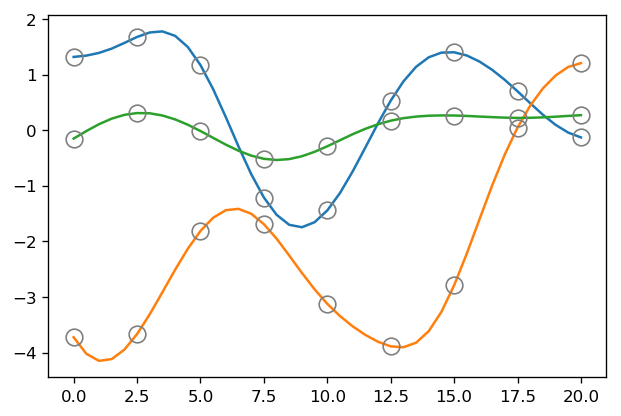

In [9]:
# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');
# toy_data_full *= (ratio**orders)[:, None]

It worked: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Now if we take the data shown above, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

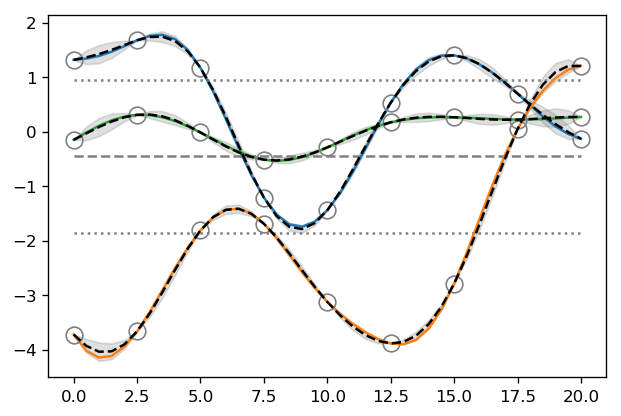

In [10]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
toy_data_pred = toy_data_full
# my_gp.beta()
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

Perhaps surprisingly, the fits seem to interpolate in a reasonable manner. However, it also seems apaprent that the green curve does not vary enough given the estimated standard deviation of the GP, and the orange curve may vary too much.

We can do better than these "by eye" checks. What does B&O model checking say about this case? First, assume that we are checking the underlying process, shown by the constant gray dotted/dashed lines above, against the colored draws.

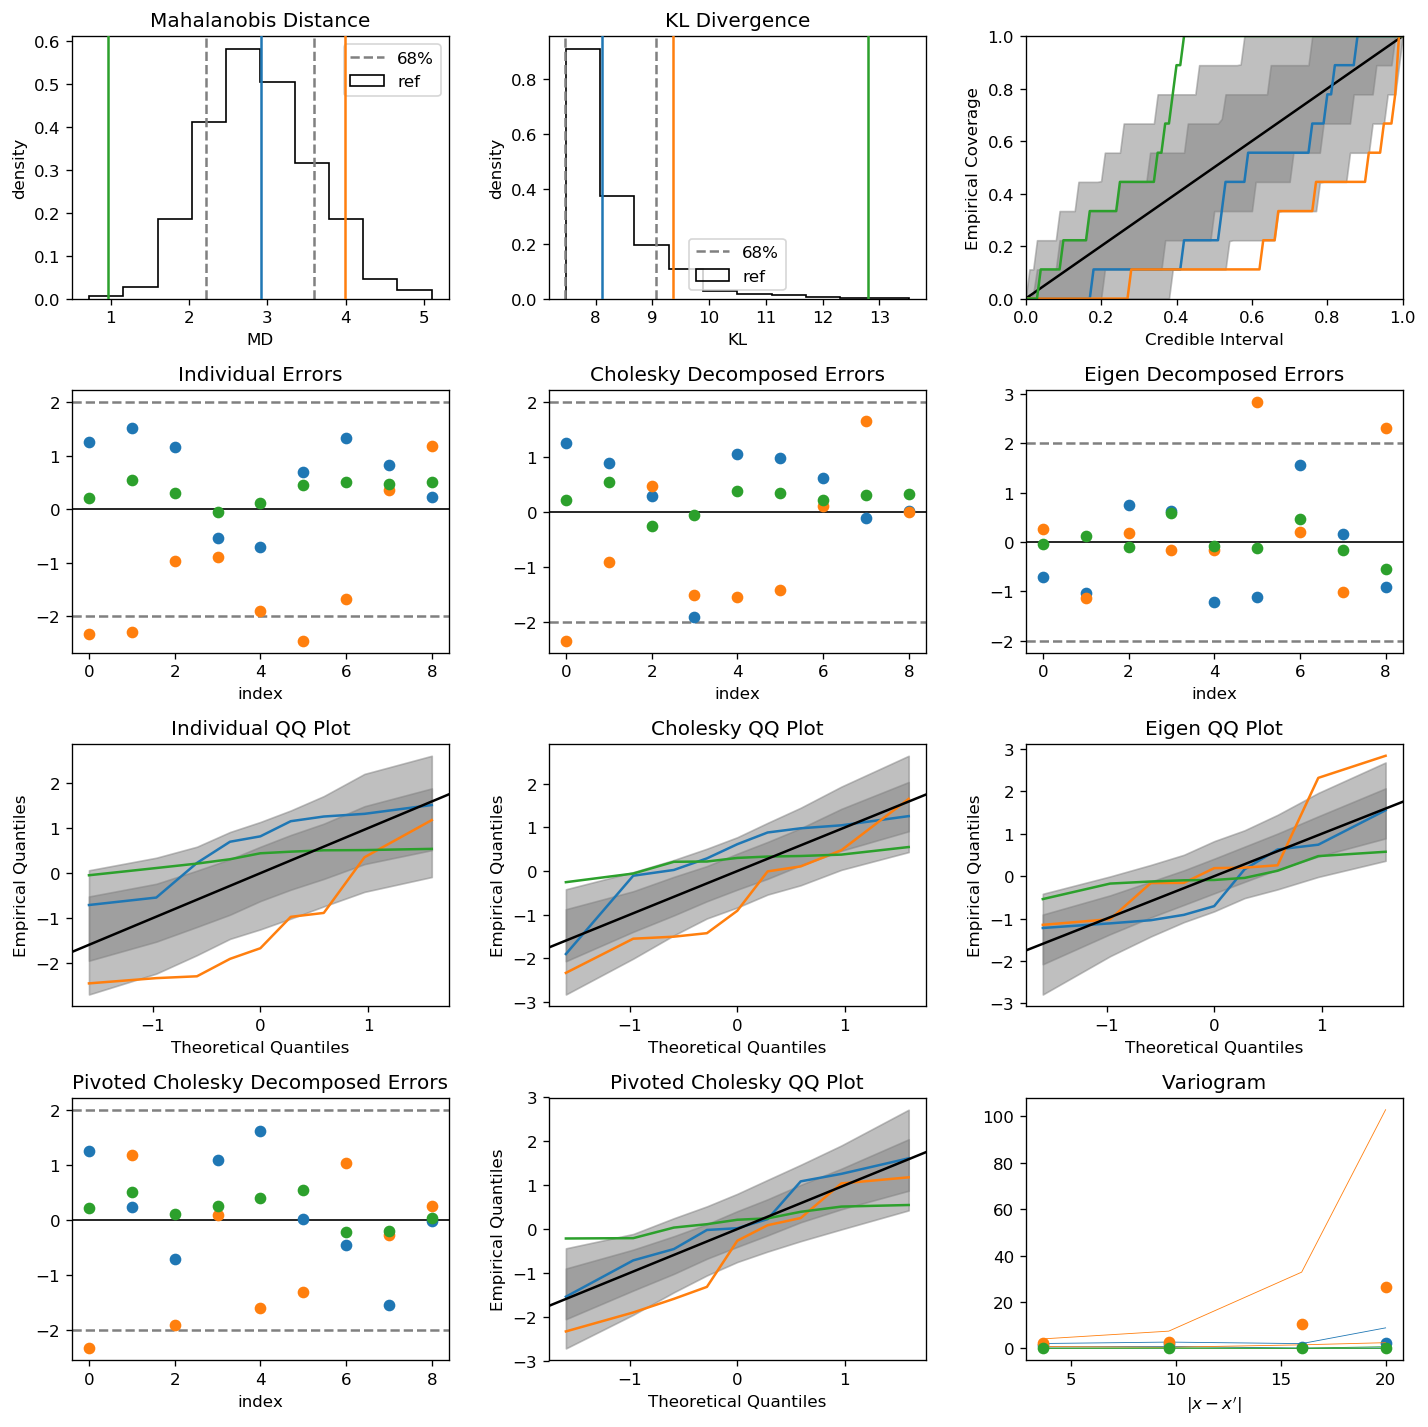

In [11]:
#First we do the diagnostics with the training data set
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gpmc = Diagnostic(fitmean, fitcov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp, vlines=vlines);

They are mostly within errors, as expected. But some tension in the model is already apparent here: e.g. aberrant behaviour of pivoted cholesky and eigenerror QQ plots.

What if we use the full dataset?

In [12]:
#At the moment we do this test against the full data set, although we may decide to remove training data later
toy_data_pred = toy_data_full

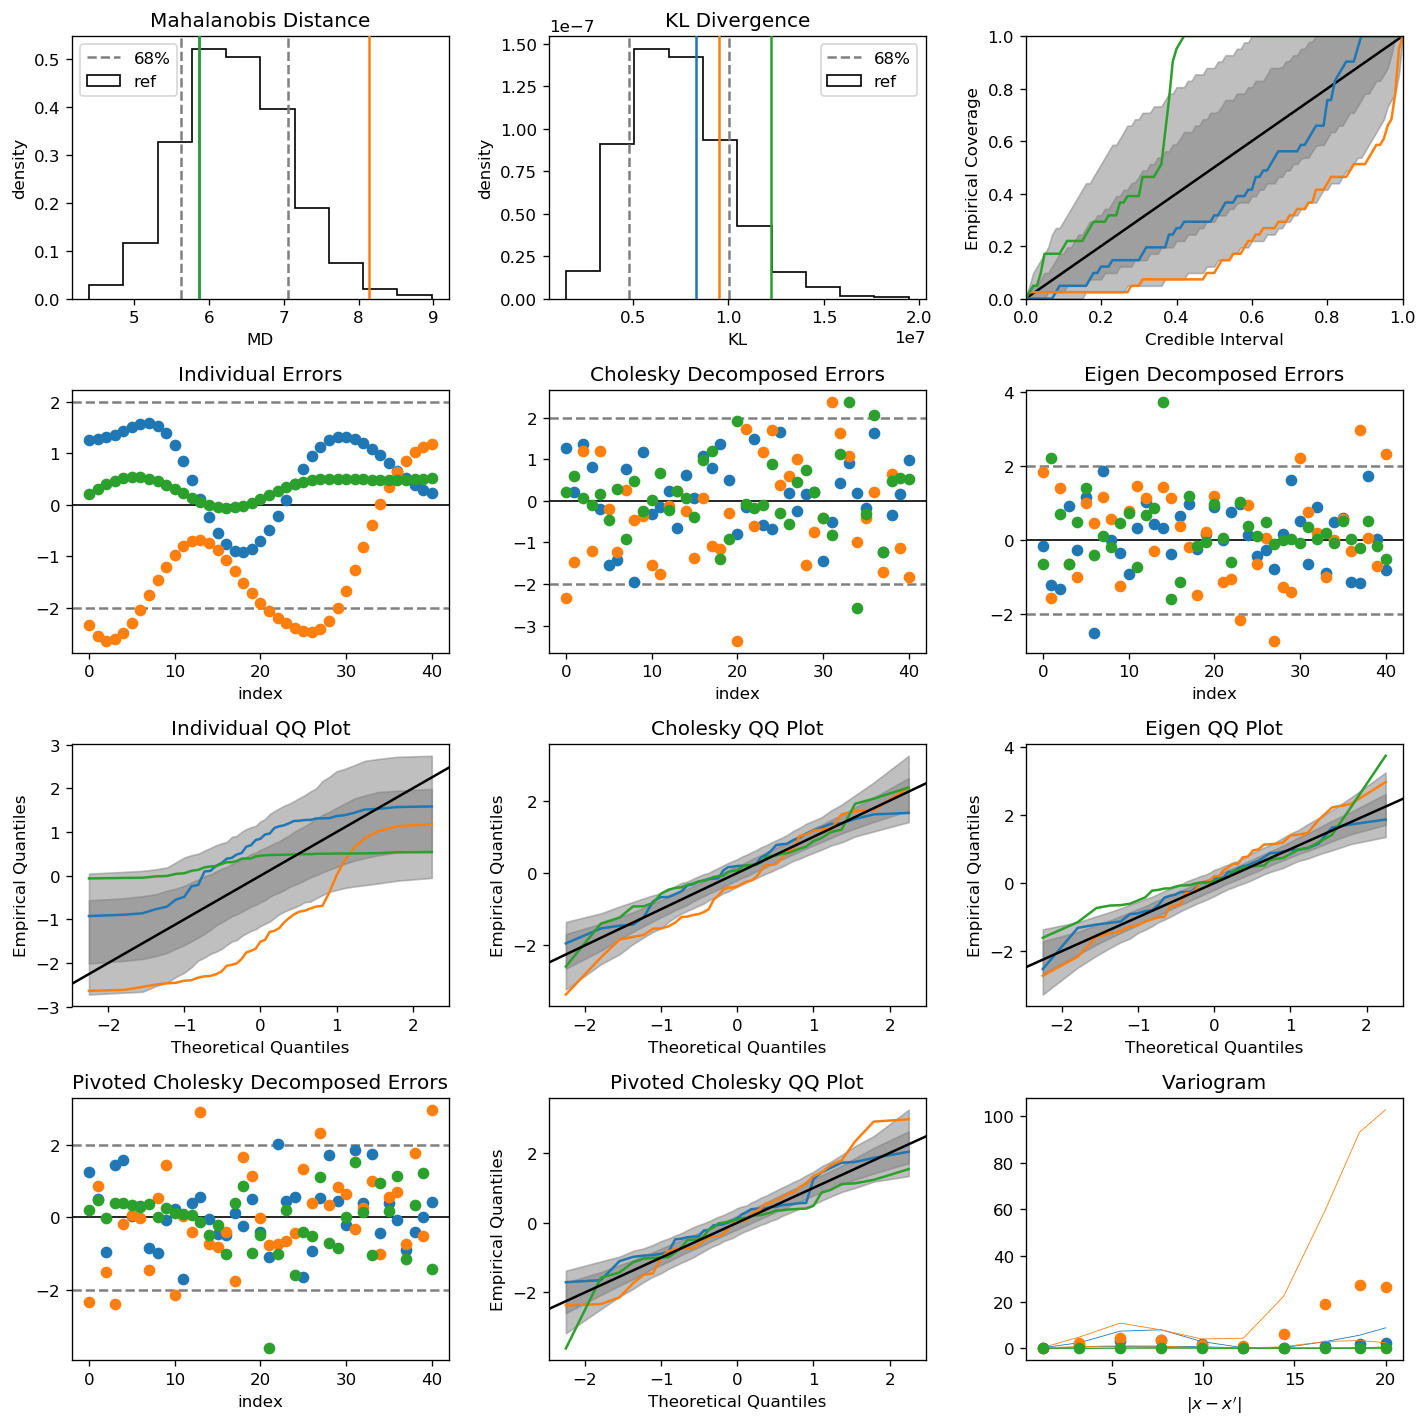

In [13]:
gp = ConjugateGaussianProcess(kernel)
gpmc_full = Diagnostic(fitmean_full, fitcov_full + nugget_sd**2 * np.eye(fitcov_full.shape[0]))
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_pred, nref=n_ref)
gd_full.plotzilla(X_full, gp, vlines=vlines);

Now things get uglier. MD for orange curve is too large. DCI plot reflects these problems. Eigen decomposed errors show structure too: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-20 show similar structure for green and perhaps for orange. The QQ plots also seem to indicate problems: especially for orange QQ plot, which is slanted compared to expectations. 

What if we performed the same model checking with the interpolants?
This time, we are comparing each colored curve to the process defined by the thin gray bands around that curve.
One potential clever way to combine the diagnostics from interpolated processes relies on the fact that the only thing that is different about the interpolating processes is their mean function that interpolates the data. If we subtract the means off the process and the data, then we are back to the simple iid case.

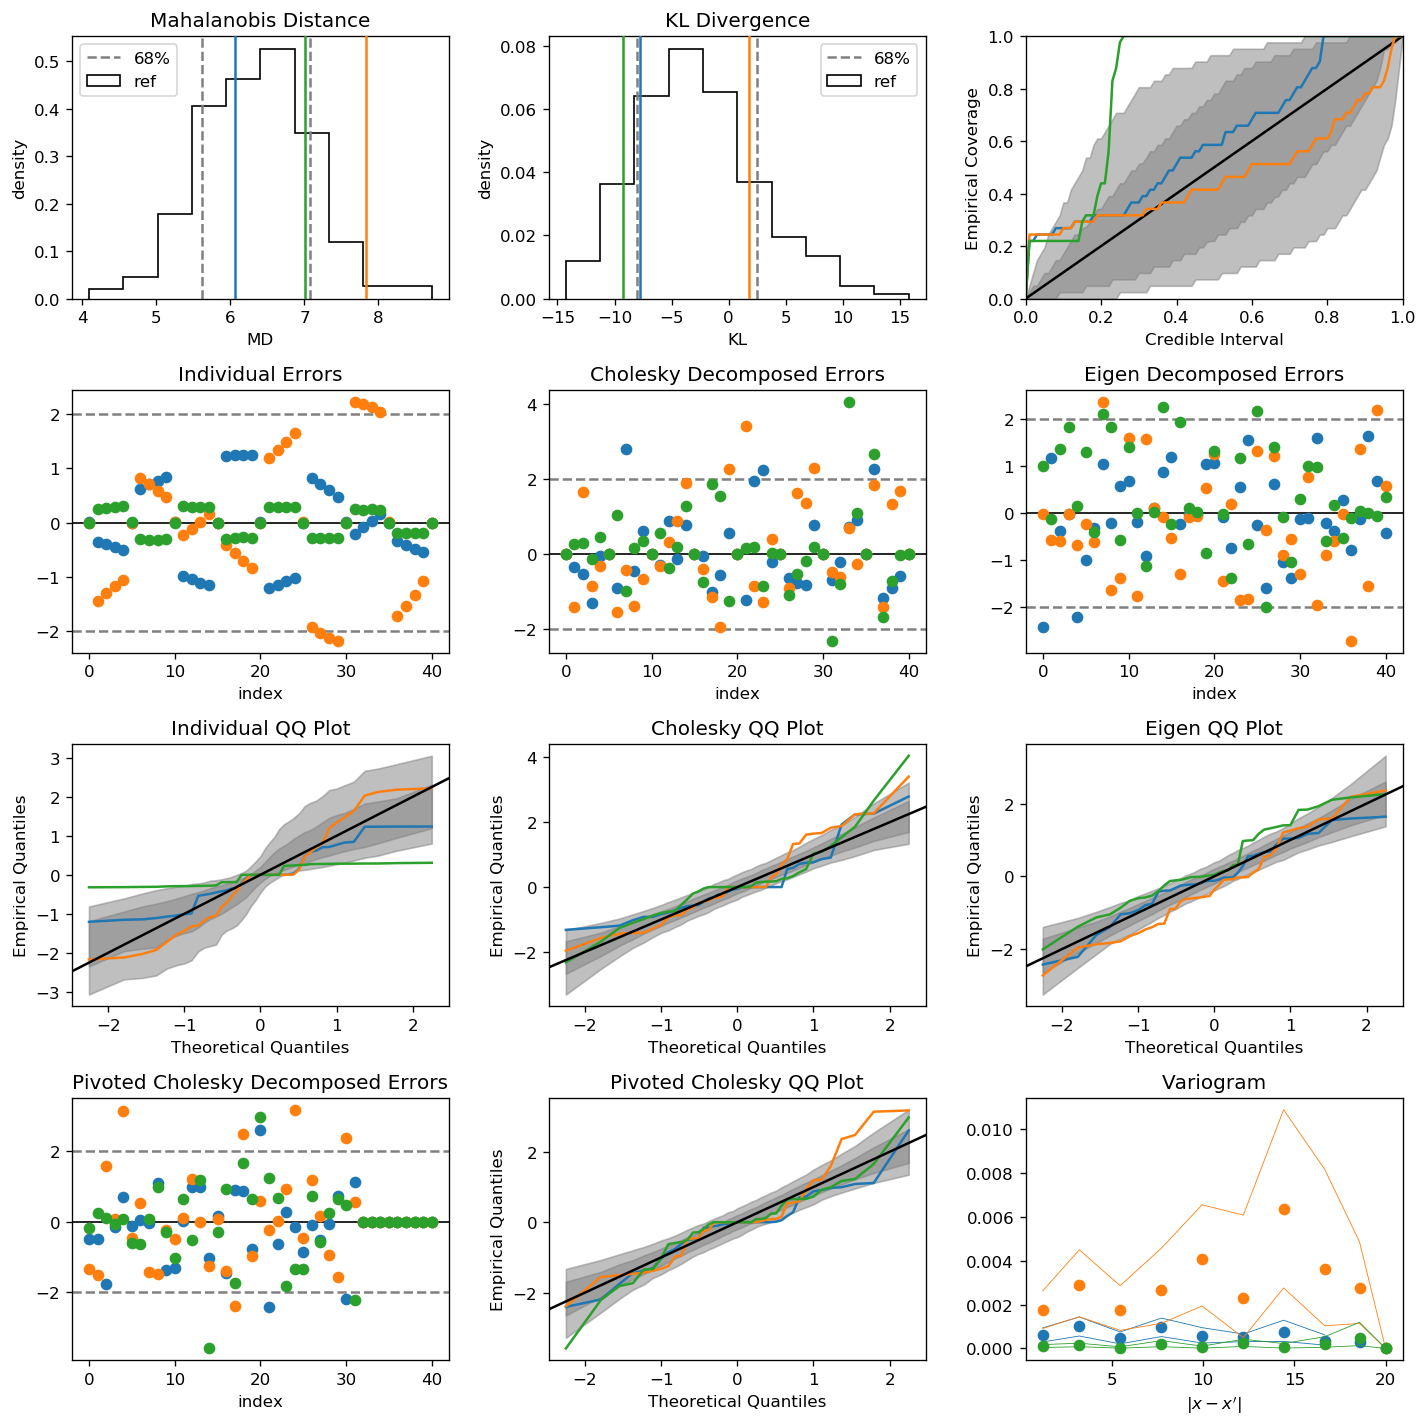

In [14]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(mean_est.shape[1]), K_pred  + nugget_sd**2 * np.eye(K_pred.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_pred - mean_est, nref=n_ref)
gd.plotzilla(X_new, gp, predict=True, vlines=vlines);

Conclusion is same and green PC (eigen) errors are clearly too small at small (large) index. Note that the green DCI plot shows "winning exhaustion" (not just tiredness any more). One also may not be concerned by shape of orange DCI plot, although a bit hard to tell with the training data included in the DCI plot. Orange curve can be diagnosed as problematic at upper end of Pivoted Cholesky QQ plot. 

## Learning the length scale

Now we will do the length-scale learning for this large-variance-shift case

In [15]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.4454545454545458}


One could also call the `likelihood` method directly with a set of correlation matrices to test.
This is essentially what's done under the hood during the fit.

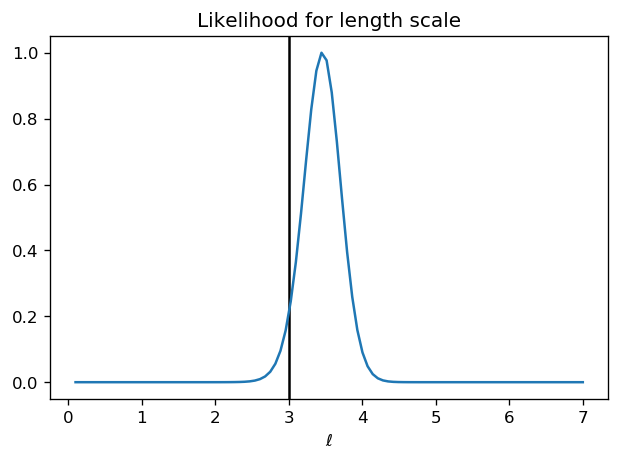

In [16]:
Rs = np.array([rbf(X, X, ls=L) for L in ls_mesh])

ls_loglike = gp.likelihood(log=True, X=X, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(ls_true, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

Likelihood estimation more-or-less works: even though we've messed with the variance, length scale is still the same for all GPs. The peak of the posterior is at a length scale that is 15% too large. This is rather more dramatic mis-estimation than Jordan found in his test. But this time the distribution is a bit broader.

How will the diagnostics look?

Setting kernel kwargs to {'ls': 3.4454545454545458}


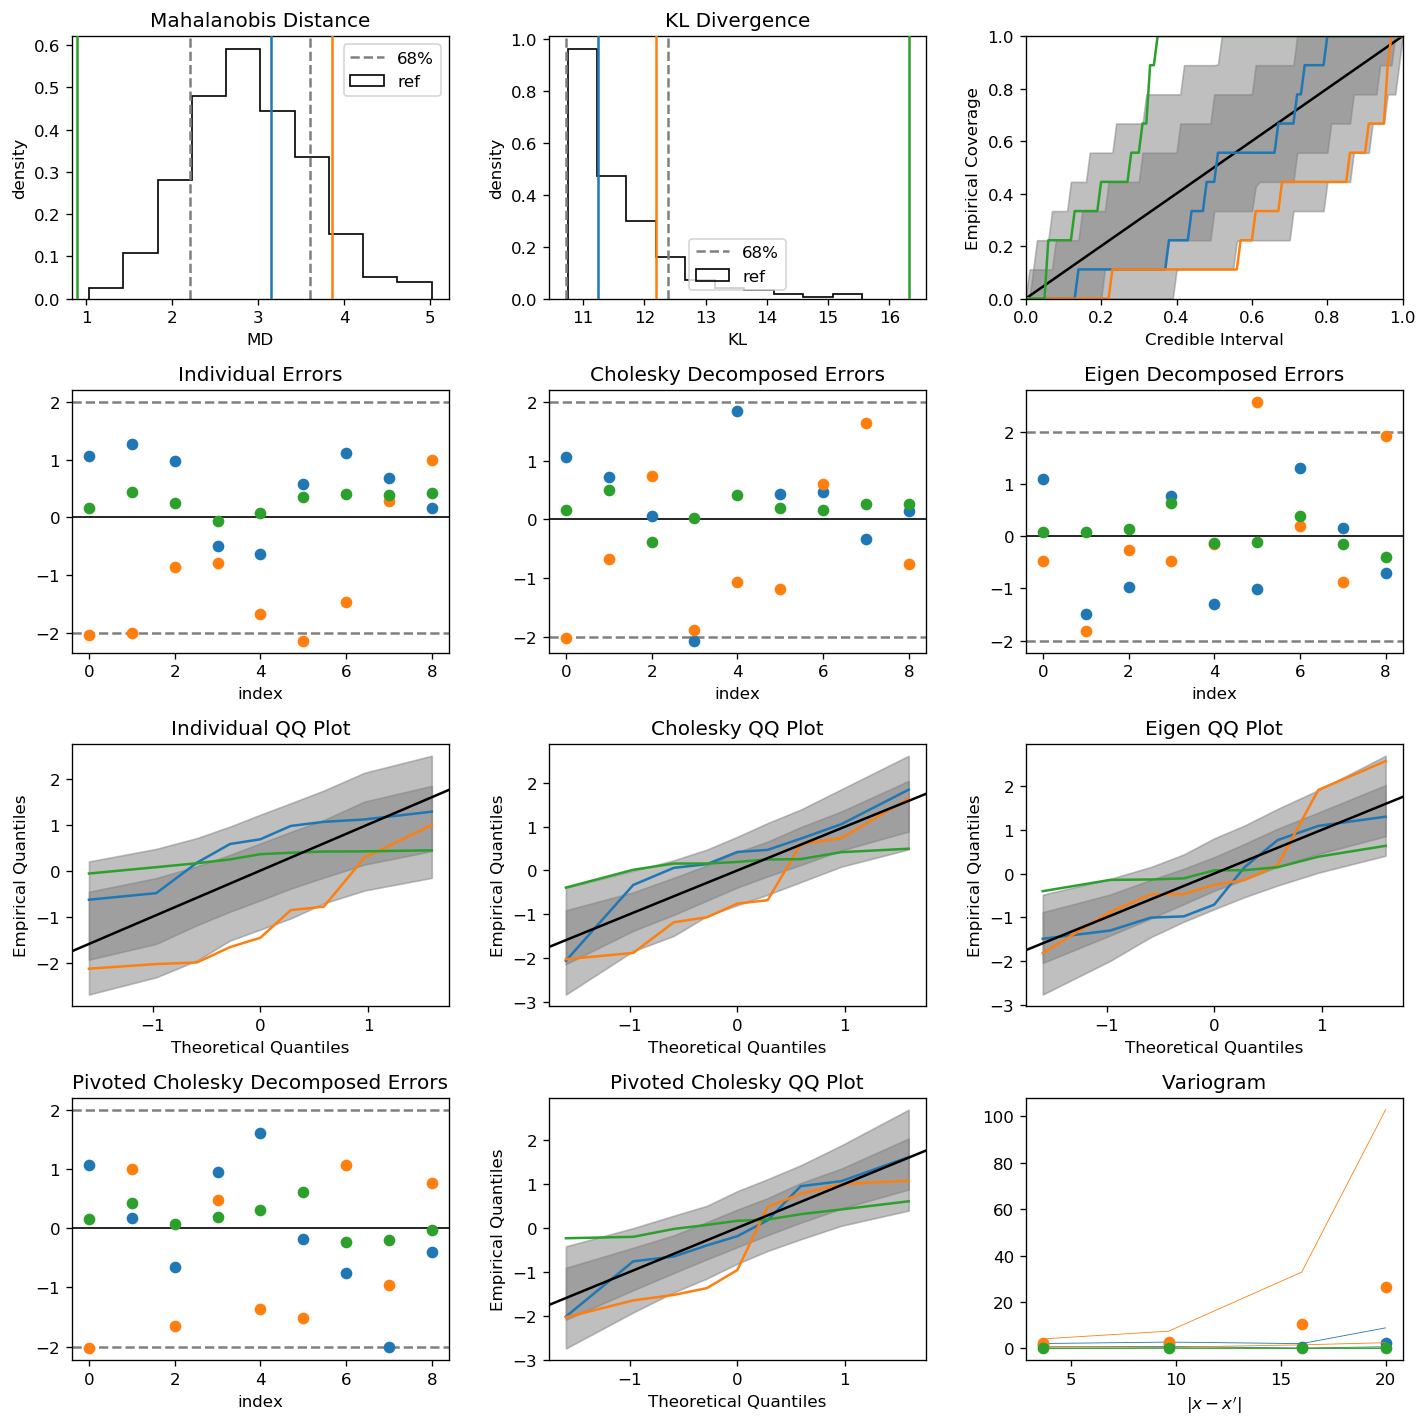

In [17]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

These look more or less as expected: green errors are still too small and orange errors too large. 

Setting kernel kwargs to {'ls': 3.4454545454545458}


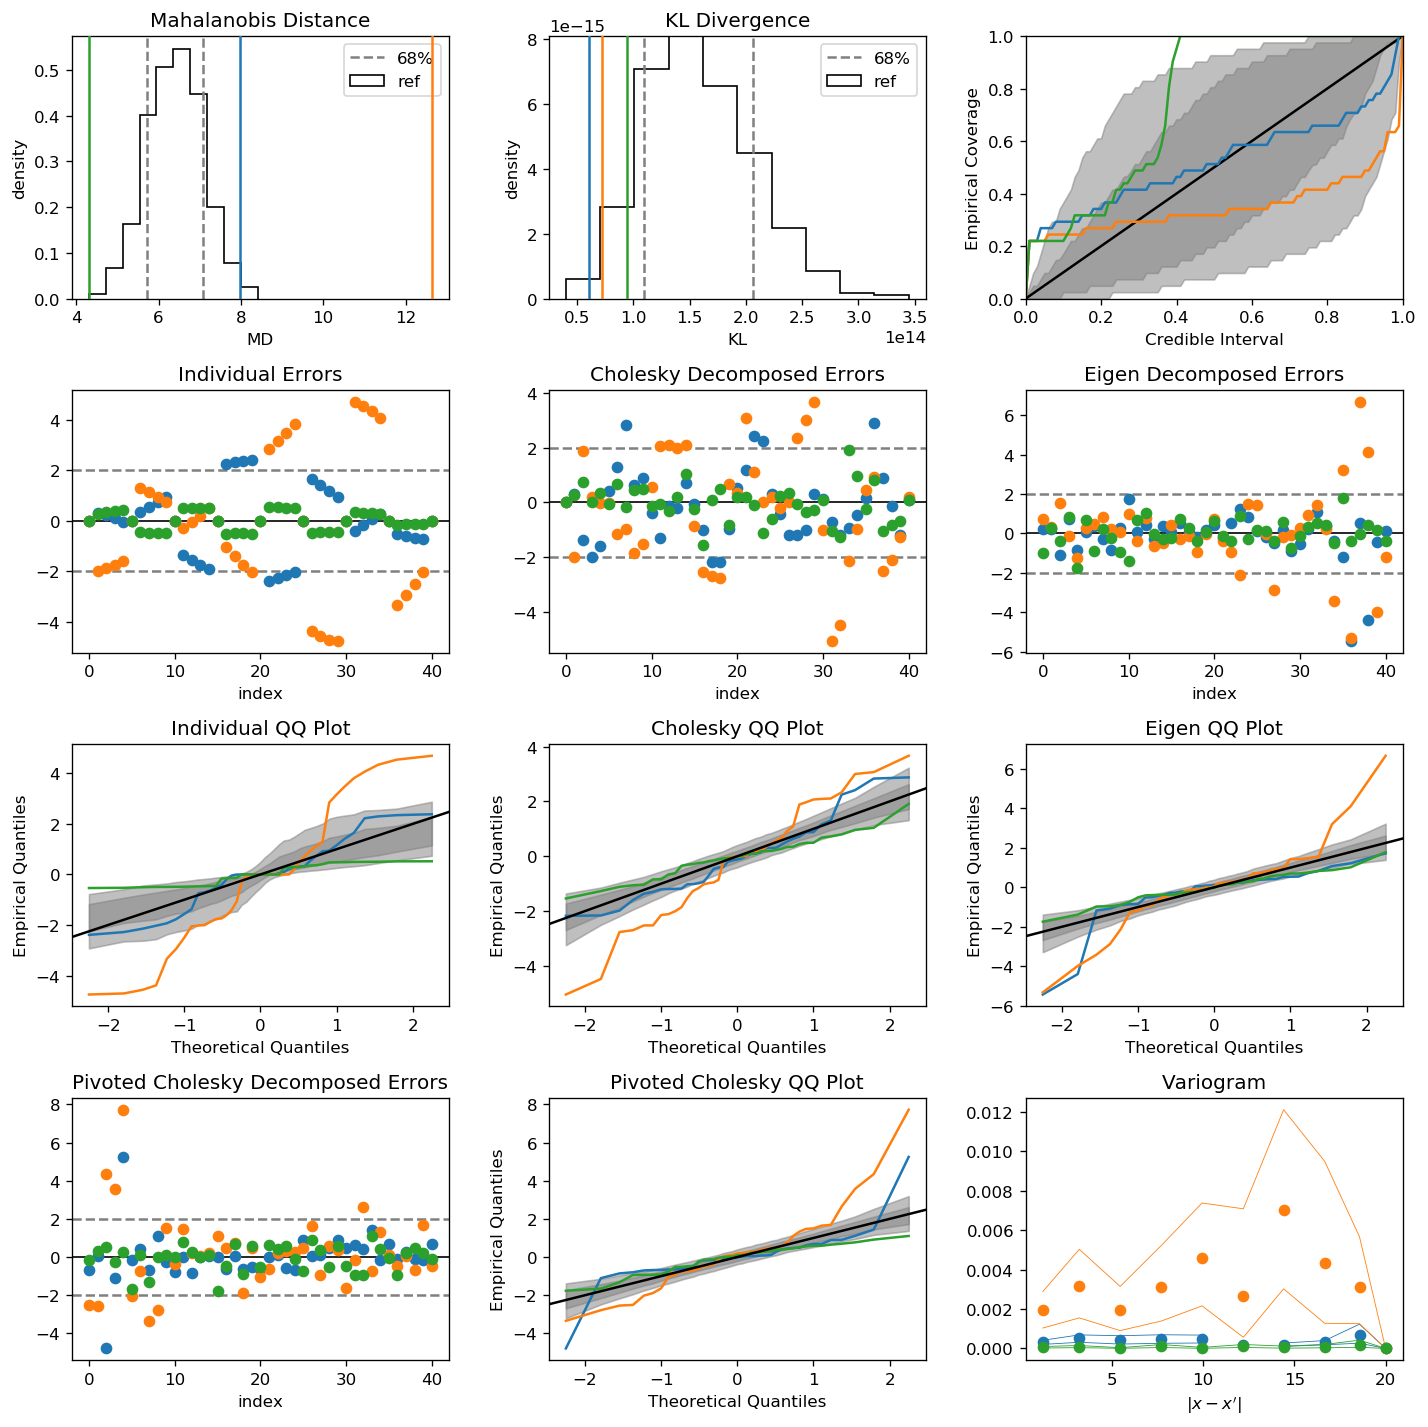

In [19]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_est.shape[1]), cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data_pred-mean_est, nref=n_ref)
gd.plotzilla(X_new, gp_static, vlines=vlines);

While orange errors are still too large and green errors too small the PC and eigen errors show much more structure now. This is, presumably, associated with the mis-estimation of the length scale.

## Breaking by variance shift: middle-sized shift
Now we make the variance shift smaller and see what happens

In [20]:
basevariance=1.0; varianceshiftfactor=3; baselengthscale=3; lengthscaleshift=0

In [21]:
true_kernel = C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvarup_kernel=C(basevariance*varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
shiftvardown_kernel=C(basevariance/varianceshiftfactor,(1e-3, 1e3)) * RBF(baselengthscale, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthup_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale+lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#shiftlengthdown_kernel=C(basevariance,(1e-3, 1e3)) * RBF(baselengthscale-lengthscaleshift, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#kernel = true_kernel

# Whether or not vertical lines or a histogram is plotted for the md and kl plots
vlines = True

gp1 = GaussianProcessRegressor(kernel=true_kernel, n_restarts_optimizer=9, optimizer=None,)
gp2 = GaussianProcessRegressor(kernel=shiftvarup_kernel,n_restarts_optimizer=9, optimizer=None)
gp3 = GaussianProcessRegressor(kernel=shiftvardown_kernel,n_restarts_optimizer=9, optimizer=None)

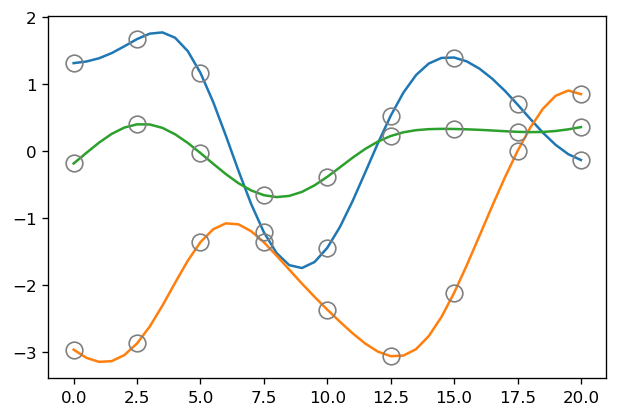

In [33]:
# Instantiate a Gaussian Process model

# gp.fit()
#toy_data_full = gp.sample_y(X_full, n_samples=n_samples, random_state=seed).T
#mean_full, cov_full = gp.predict(X_full, return_cov=True)
#The above three lines of code get replaced by something a bit more complicated when we have different GPs that we want to lump together as if they were one.
#Note that we gave up returning the covariances of the GP for which we generate the data since we decided we should not be using them.
seed=2; toy_data_full_1 = gp1.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_2 = gp2.sample_y(X_full, n_samples=1, random_state=seed).T
seed=seed + 1; toy_data_full_3 = gp3.sample_y(X_full, n_samples=1, random_state=seed).T
#Note also that I (DP) have switched the seed after each call, to try and get GPs that start at somewhat different points. This may be unnecessary? But I hope
#it is at least not wrong. :) 


mean_full_1 = gp1.predict(X_full)
mean_full_2 = gp2.predict(X_full)
mean_full_3 = gp3.predict(X_full)

#mean = mean_full[mask]
#cov = cov_full[mask][:, mask]
#I comment out these two lines since I do not think we should be using these quantities: the code should interact with the underlying GP
#only through the toy_data, which we now generate.

toy_data_full = np.concatenate((toy_data_full_1,toy_data_full_2,toy_data_full_3),axis=0)
mean_full = np.concatenate(([mean_full_1],[mean_full_2],[mean_full_3]),axis=0)

toy_data = toy_data_full[:, mask]
X = X_full[mask]

plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

Remember: blue curve is the original variance (1), orange has a larger variance, and green a smaller one. 

Once again, estimate the hyperparameters using conjugacy, and fit to the data, we get the plot shown below:

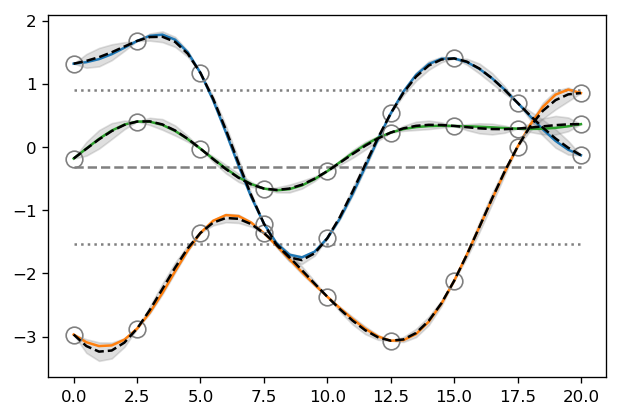

In [34]:
kernel= C(1.0, (1e-3, 1e3)) * RBF(3, (1e-2, 1e2)) + WhiteKernel(nugget_sd**2)
#This defines the GP for the start of the fitting. DP shifted this line
#here in order to make sure that we were not inadvertantly talking to 
#the underlying GP.

my_gp = ConjugateGaussianProcess(kernel)
my_gp.fit(X, toy_data)
# X_new = X_full[~mask]
# toy_data_pred = toy_data_full[:, ~mask]

#compute the mean and covariance of the fitted GP at the training-set points
fitmean = my_gp.mean()
fitcov = my_gp.cov()

#compute the values of the fitted GP at all the data points on all the curves, as well as associated curve-by-curve means & covariances
X_new = X_full
m_pred, K_pred = my_gp.predict(X_new, return_cov=True, pred_noise=True)
# print(np.diag(K_pred))
sd_pred = np.sqrt(np.diag(K_pred))

#compute the mean and covaraince of the overall GP at the set X_full, note that a nugget should be added to fitcov_full when it is used below.
fitmean_full = my_gp.mean(X_new) 
fitcov_full = my_gp.cov(X_new,X_new) 

# Plot the underlying process
plt.plot(X.ravel(), my_gp.mean(), ls='--', c='gray')
plt.plot(X.ravel(), my_gp.mean() + my_gp.sd(), ls=':', c='gray')
plt.plot(X.ravel(), my_gp.mean() - my_gp.sd(), ls=':', c='gray');

# Now the true data
plt.plot(X_full.ravel(), toy_data_full.T);
plt.plot(X.ravel(), toy_data.T, ls='', marker='o', fillstyle='none', markersize=10, c='gray');

# The predicted interpolants and their errors
plt.plot(X_new.ravel(), m_pred.T, c='k', ls='--', label='pred');
for m in m_pred:
    plt.fill_between(X_new.ravel(), m + 2*sd_pred, m - 2*sd_pred, color='gray', alpha=0.25)
# plt.legend();

This time the standard deviation still comes out close to one, but the mean is significantly mis-estimated. How will this show up in the B&O model checking? Interpolants once again do not look too bad "by eye".

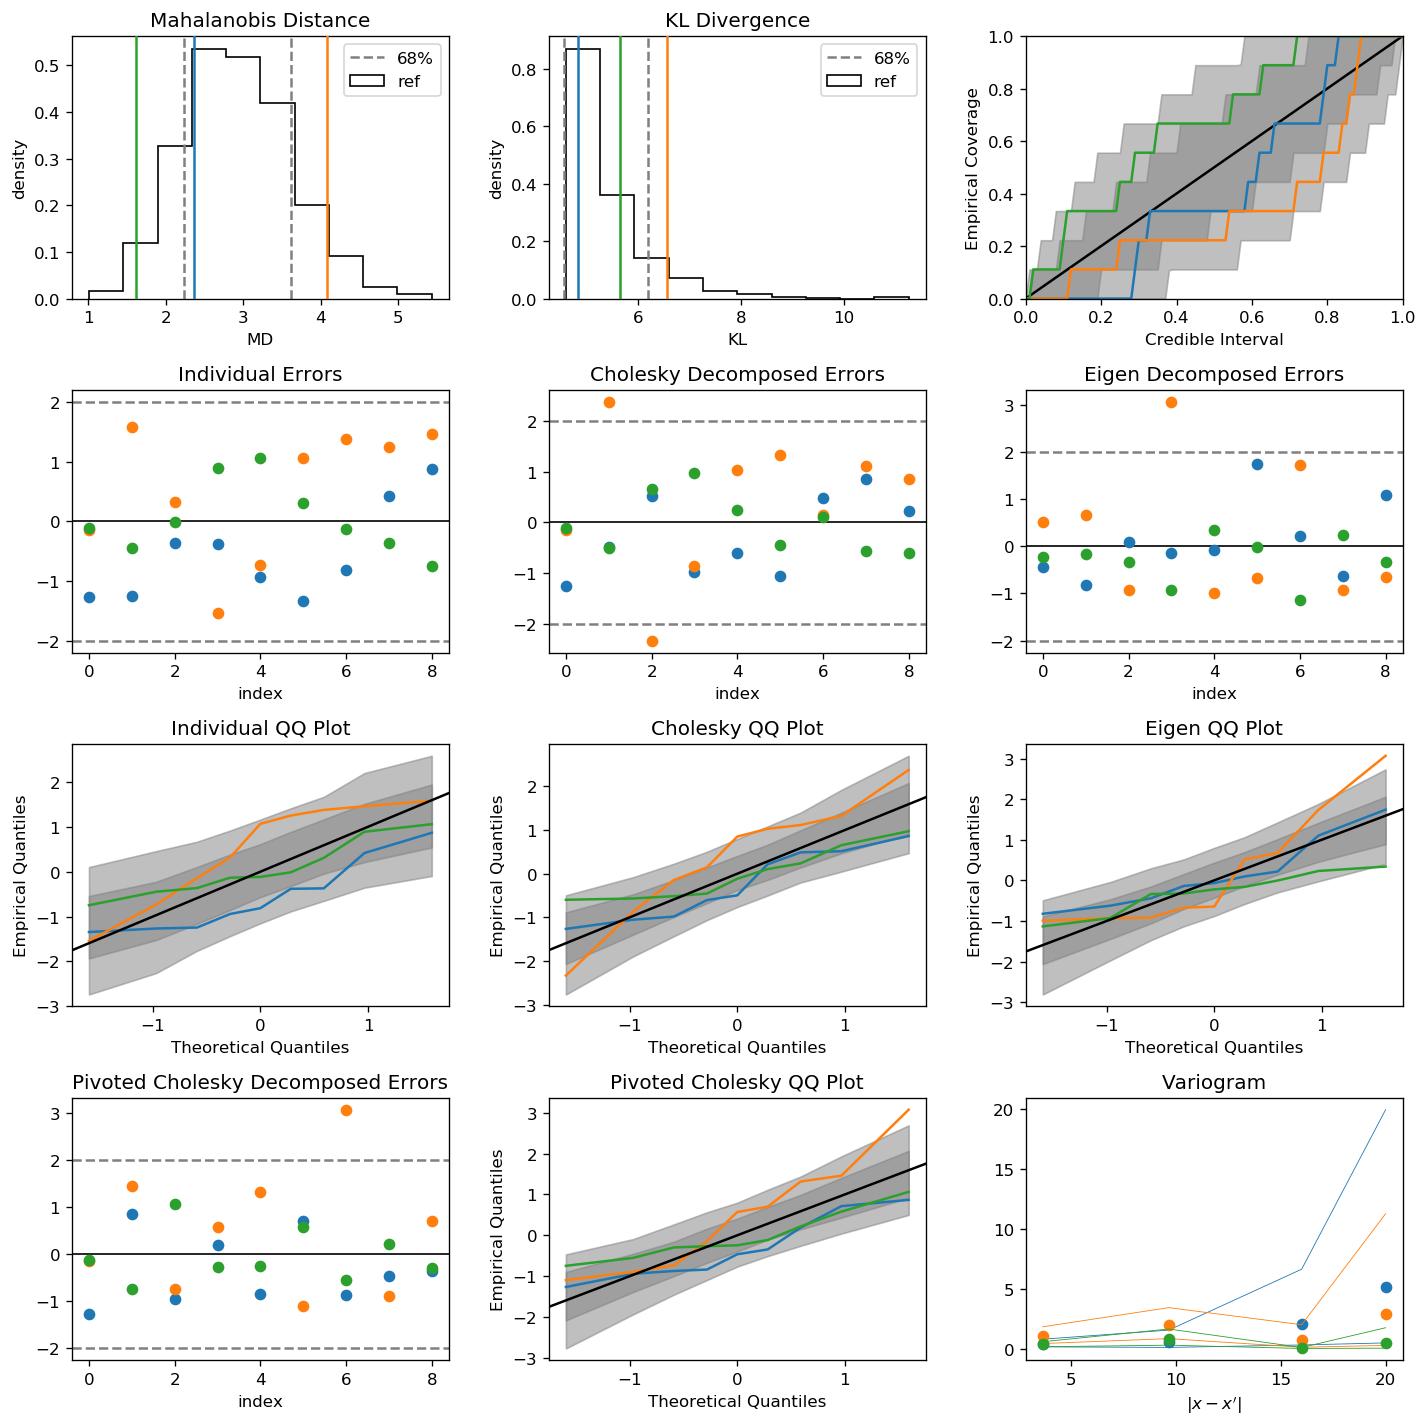

In [25]:
#First we do the diagnostics with the training data set
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gpmc = Diagnostic(fitmean, fitcov)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp, vlines=vlines);

Individual errors look okay, but once one accounts for correlations one perhaps sees too many (or not enough) outliers for orange (green) curve.

What if we use the full dataset?

In [26]:
#At the moment we do this test against the full data set, although we may decide to remove training data later
toy_data_pred = toy_data_full

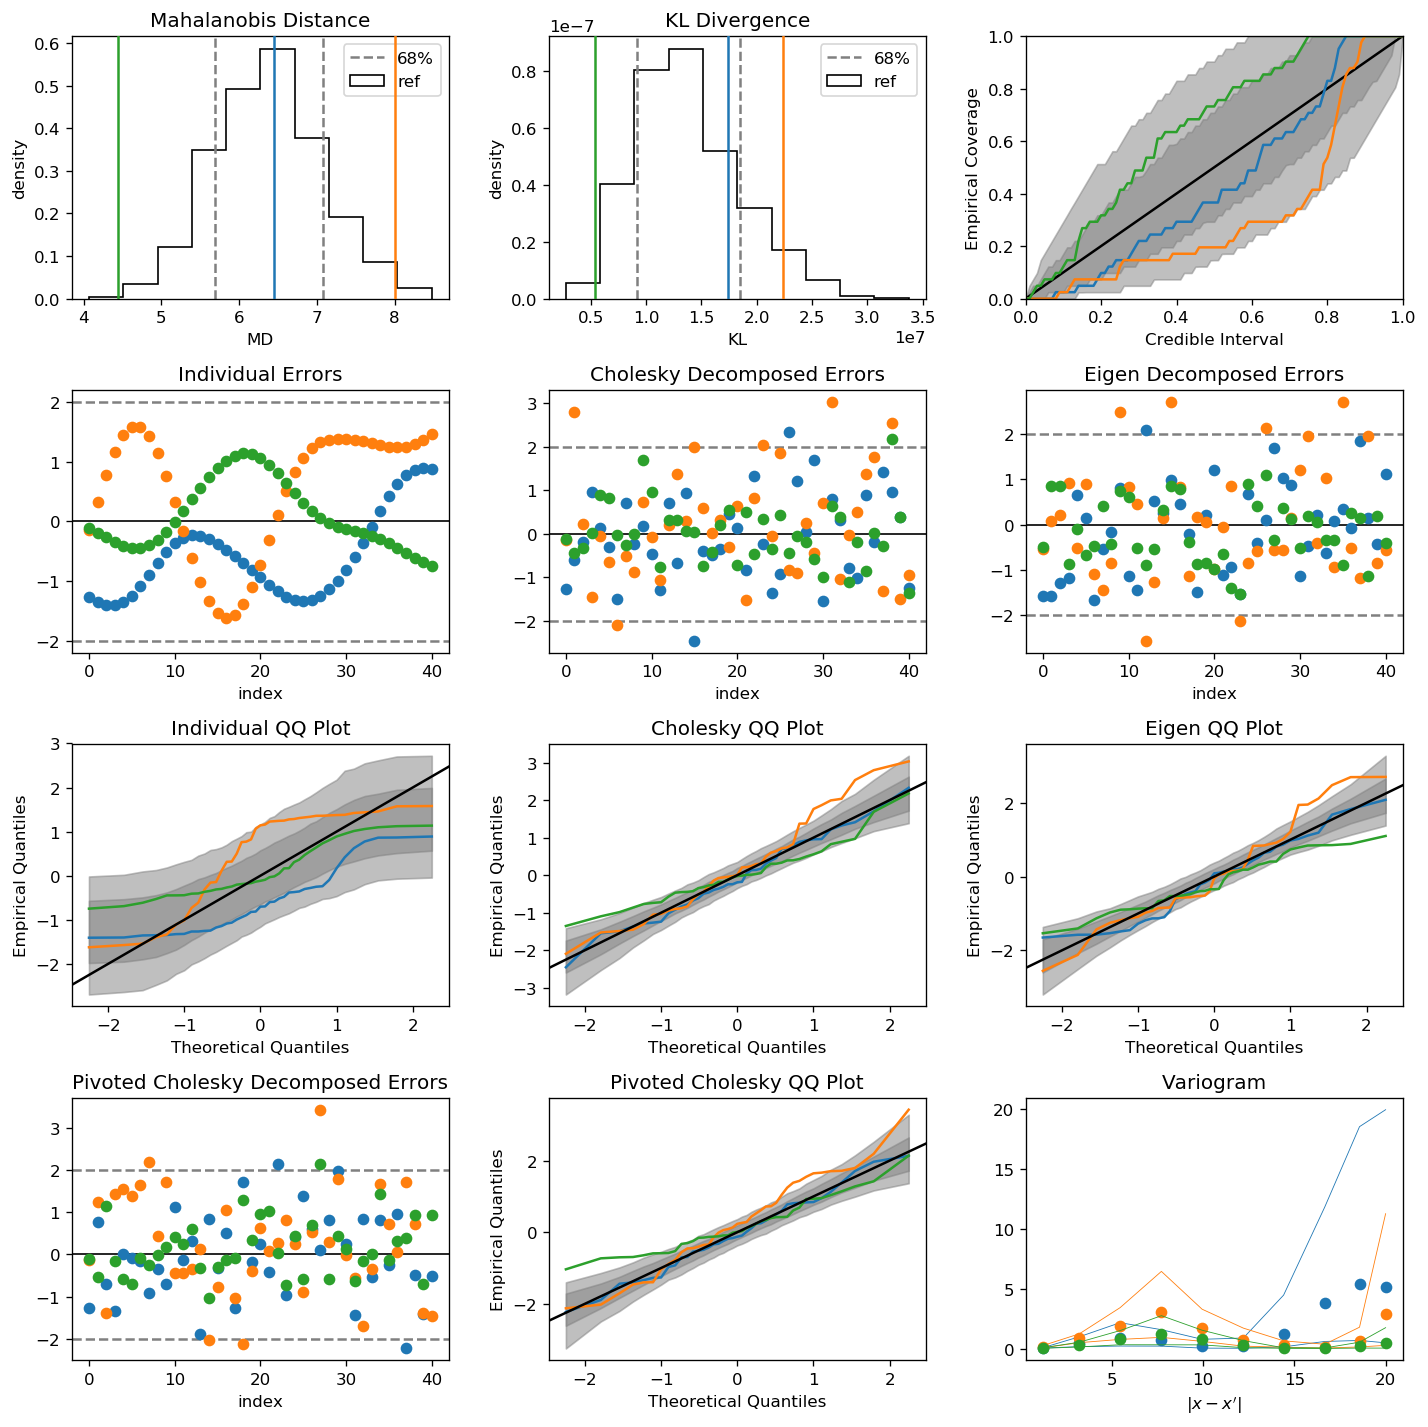

In [27]:
gp = ConjugateGaussianProcess(kernel)
gpmc_full = Diagnostic(fitmean_full,fitcov_full + nugget_sd**2 * np.eye(fitcov_full.shape[0]))
gd_full = GraphicalDiagnostic(gpmc_full, toy_data_pred, nref=n_ref)
gd_full.plotzilla(X_full, gp, vlines=vlines);

Once again things get uglier. MD for orange curve is again too large, and that for green is too small. DCI plot reflects these problems. Eigen decomposed errors again show structure: errors are too large (small) at high index for orange (green). Pivoted Cholesky errors from index 1-20 show similar issues to eigen-errors at large index for green but not really for orange. QQ plots look sort of okay apart from lower (upper) end for PC (eigen) error case for green curve. 

Now we again do the same model checking with the interpolants.

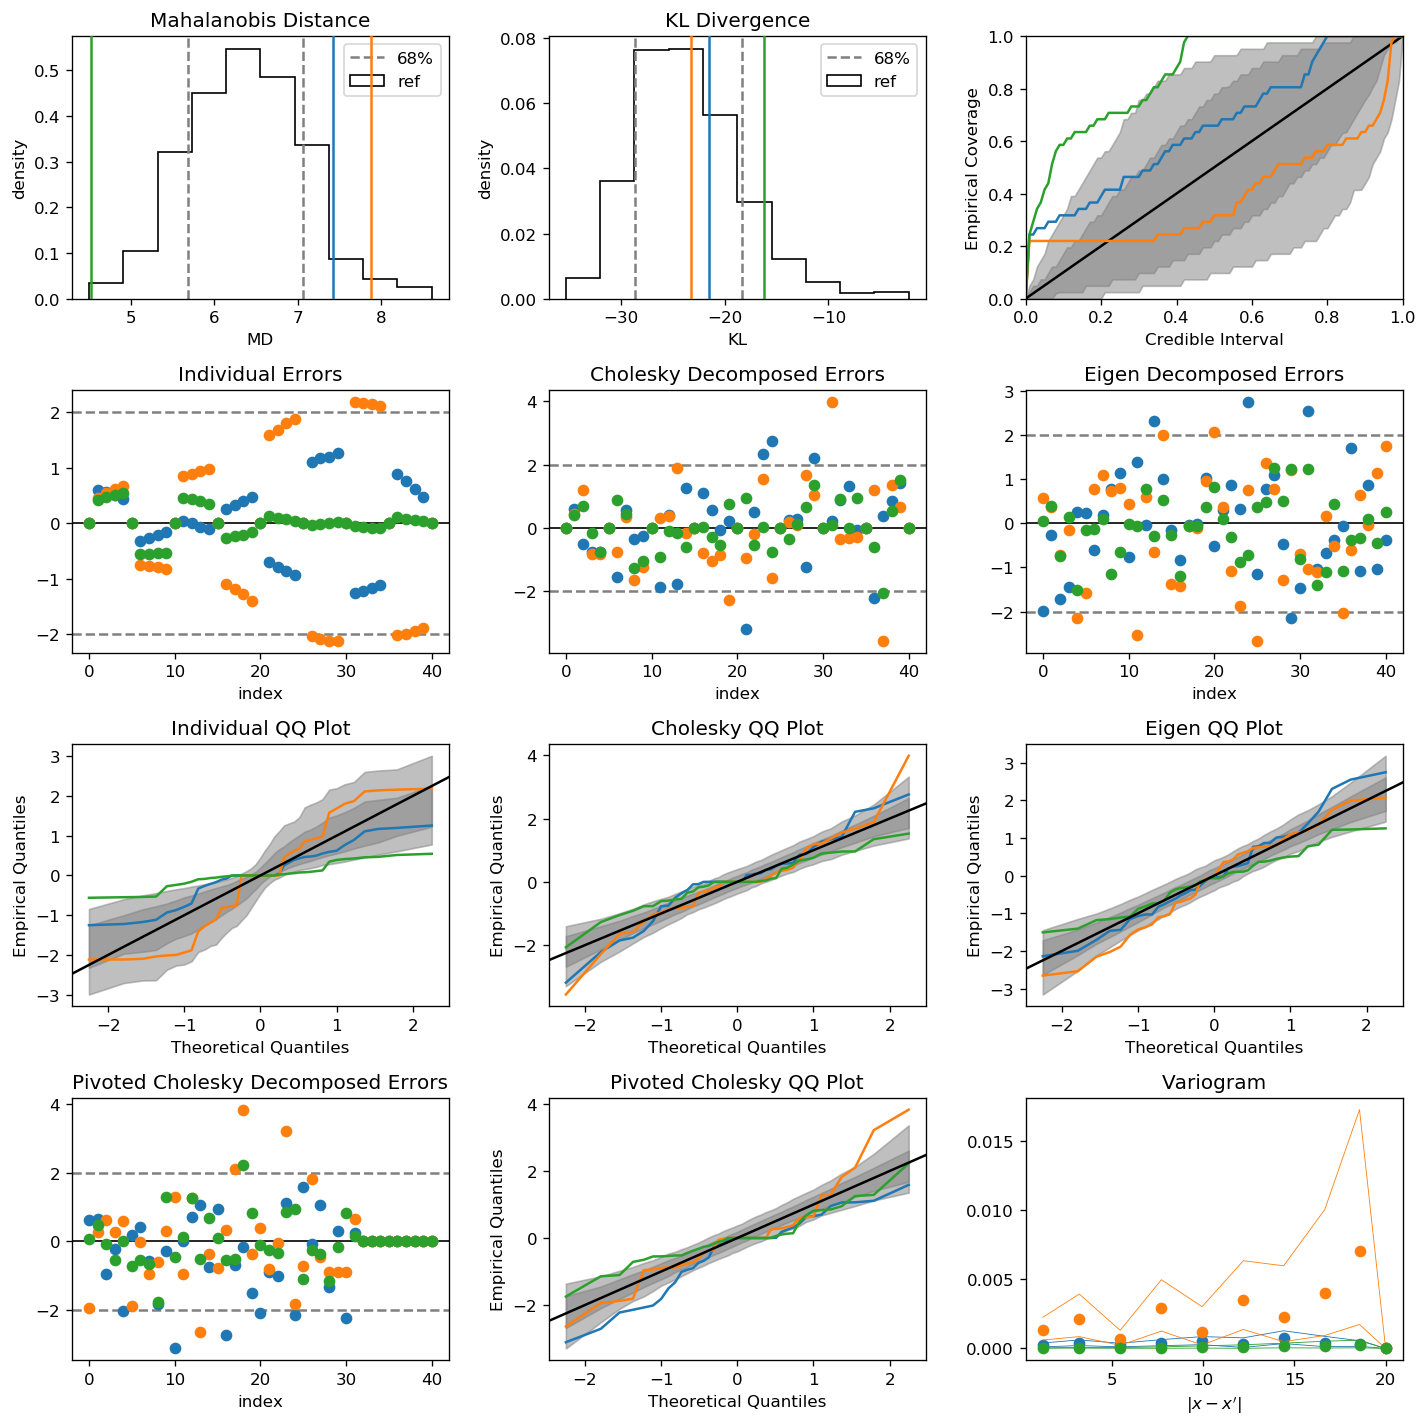

In [28]:
np.random.seed(seed)
gp = ConjugateGaussianProcess(kernel)
gp.fit(X, toy_data, noise_sd=nugget_sd)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)
# print(mean_est.shape)
gpmc = Diagnostic(np.zeros(m_pred.shape[1]), K_pred + nugget_sd**2 * np.eye(K_pred.shape[0]))
# gpmc = GPModelChecking(np.zeros_like(mean_est[0]), cov_est, df=2*gp.a())
gd = GraphicalDiagnostic(gpmc, toy_data_pred - m_pred, nref=n_ref)
gd.plotzilla(X_new, gp, predict=True, vlines=vlines);

This time the orange and green MDs are still outliers. Do DCI plots show problems? Definitely for green plot. But again, difficult to diagnose for orange plot. PC QQ plot shows problems with orange errors at upper end, i.e., too many that are too big. But note that blue curve in this QQ plot also seems problematic: is this a consequence of mean misestimation? Indeed, blue curve would be flagged as problematic on several of these diagnostics.

## Learning the length scale: medium-variance-shift case

Now we will do the length-scale learning for this medium-variance-shift case

In [35]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)

Setting kernel kwargs to {'ls': 3.375757575757576}


One could also call the `likelihood` method directly with a set of correlation matrices to test.
This is essentially what's done under the hood during the fit.

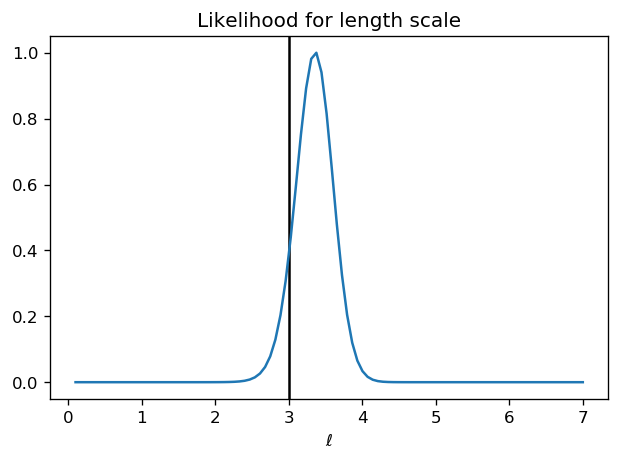

In [36]:
Rs = np.array([rbf(X, X, ls=L) for L in ls_mesh])

ls_loglike = gp.likelihood(log=True, X=X, corr=Rs)
ls_like = np.exp(ls_loglike - np.max(ls_loglike))

ax = plt.gca()
ax.set_xlabel(r'$\ell$')
ax.set_title('Likelihood for length scale')
ax.axvline(ls_true, 0, 1, c='k')
ax.plot(ls_mesh, ls_like);

Likelihood estimation more-or-less works: even though we've messed with the variance, length scale is still the same for all GPs. The peak of the posterior is at a length scale is at an even larger l here. But this time the distribution is a bit broader.

How will the diagnostics look?

Setting kernel kwargs to {'ls': 3.375757575757576}


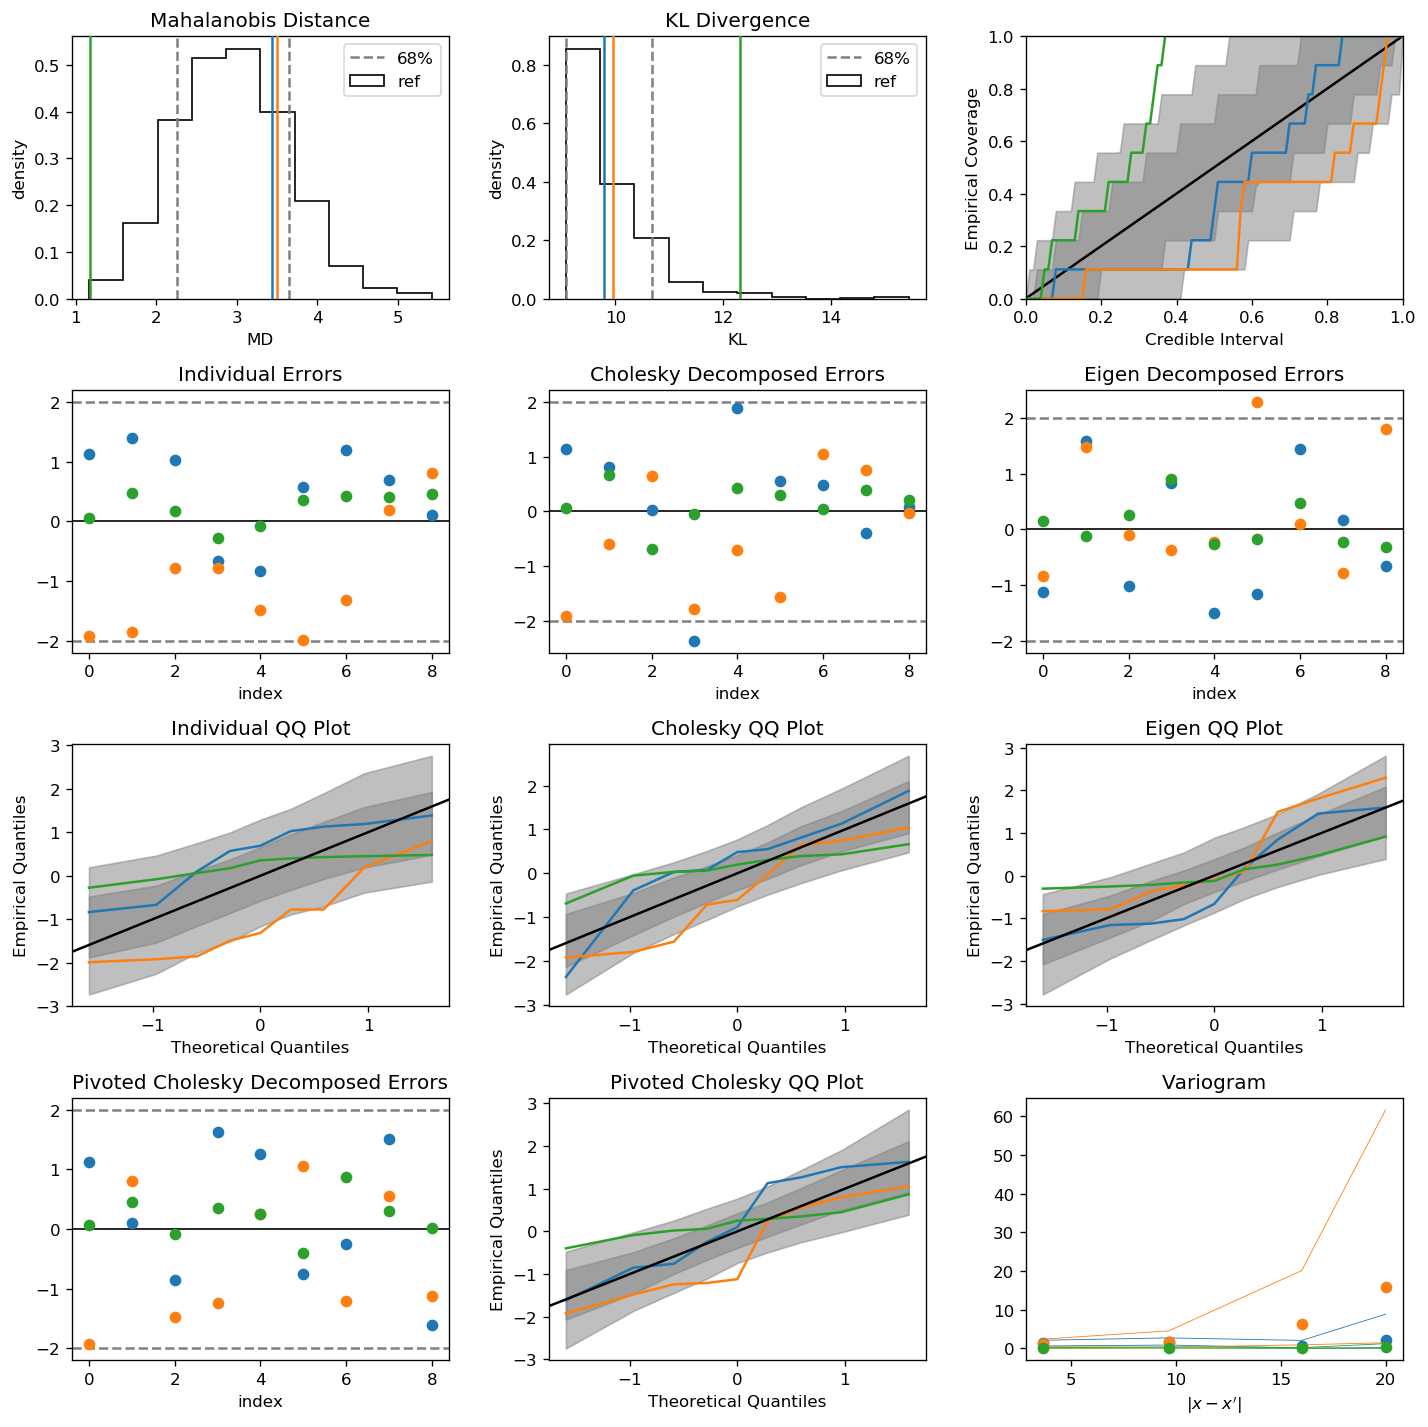

In [37]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.mean(), gp.cov()

gpmc = Diagnostic(mean_est, cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data, nref=n_ref)
gd.plotzilla(X, gp_static, vlines=vlines);

These look more or less as expected: green errors are still too small and orange errors too large. 

Setting kernel kwargs to {'ls': 3.375757575757576}


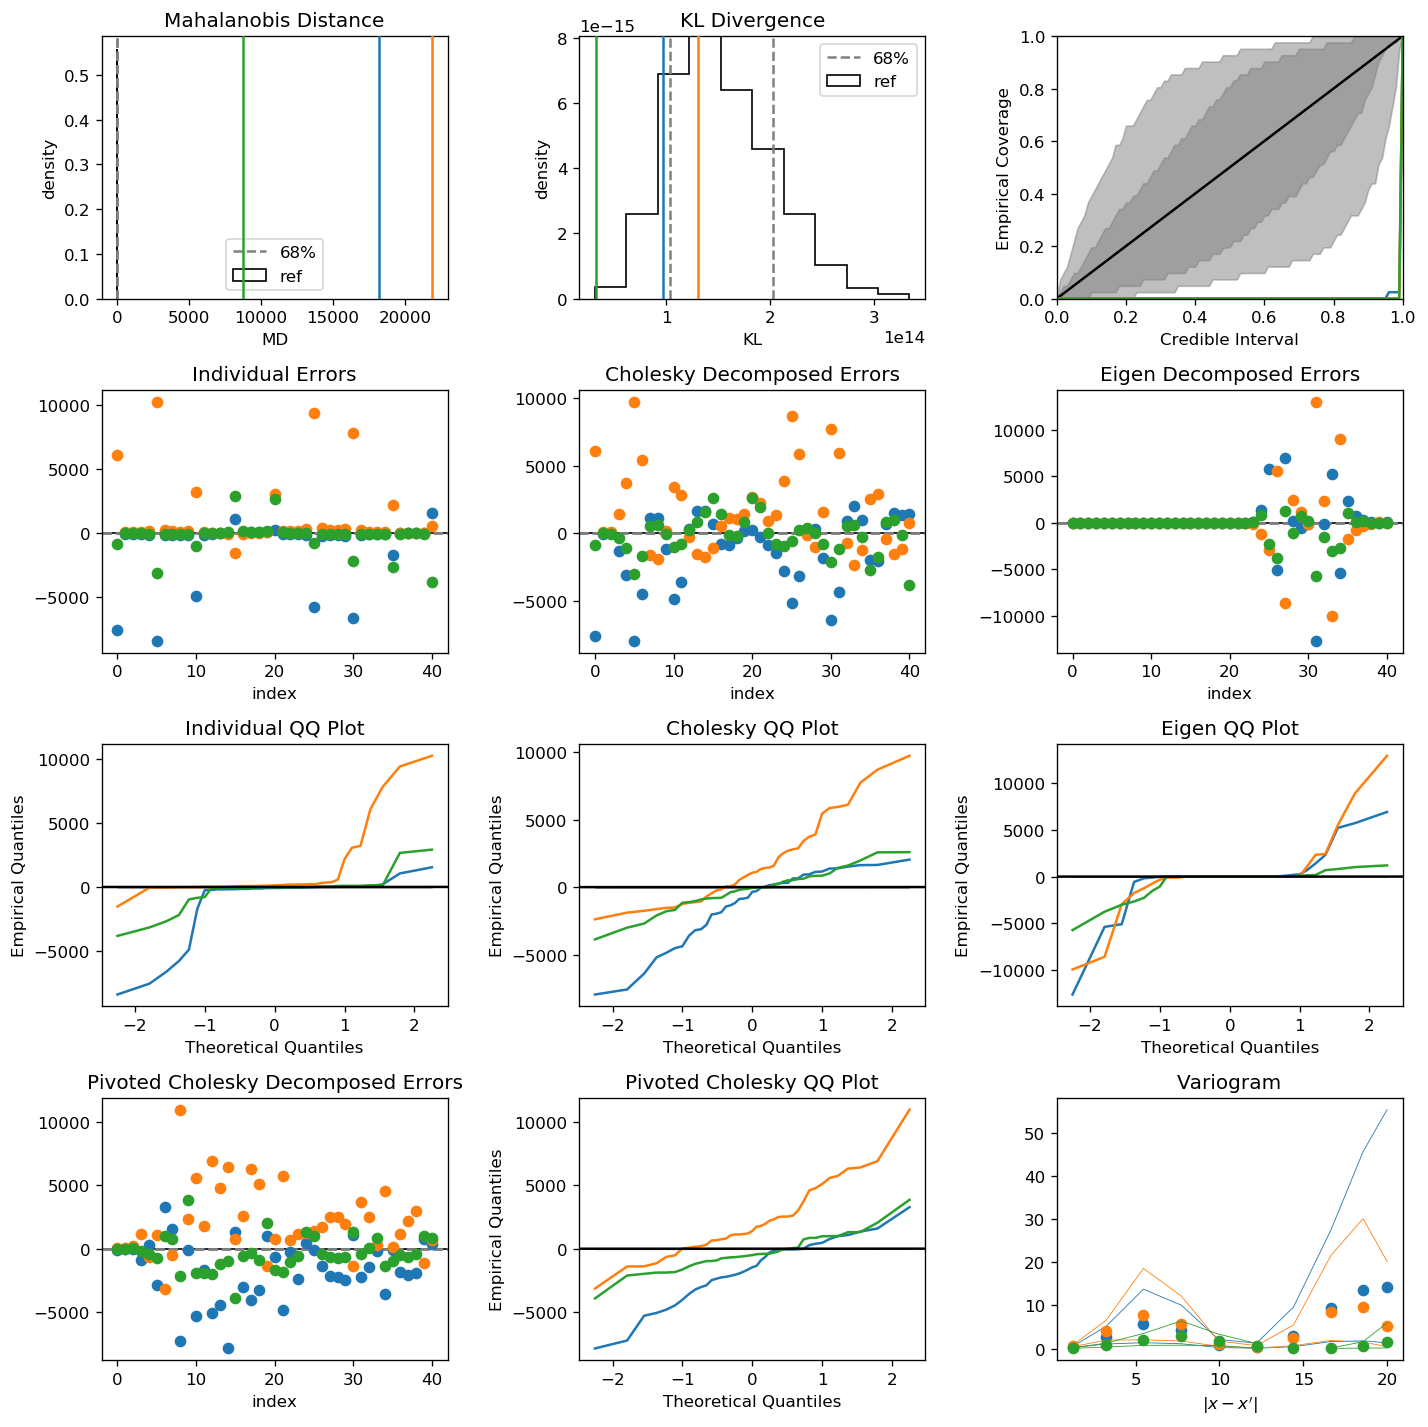

In [39]:
ls_mesh = np.linspace(0.1, 7, 100)
gp = ConjugateGaussianProcess(rbf, kernel_kws=[{'ls': ls} for ls in ls_mesh])
gp.fit(X, toy_data, noise_sd=nugget_sd)
best_fit = gp.kernel_kws  # These are updated by the fit

# Don't update the fit everytime you see new data, that takes too long. just use MAP values from now on
gp_static = ConjugateGaussianProcess(rbf, kernel_kws=best_fit)
mean_est, cov_est = gp.predict(X_new, return_cov=True, pred_noise=True)

gpmc = Diagnostic(np.zeros(mean_est.shape[1]), cov_est)
gd = GraphicalDiagnostic(gpmc, toy_data_pred-mean_est, nref=n_ref)
gd.plotzilla(X_new, gp_static, vlines=vlines);

Mis-estimation of length scale in this case causes even the blue PC errors to go a bit crazy at small index. From these diagnostics you might conclude that green curve is OK, and blue & orange ones are mis-fit. That, indeed, is what the computation of MD tells one right off the bat.

## Todo

I want to improve the code, check for bugs/errors, add more examples, and add more model checking diagnostics. We must find where the model fails, and which diagnostics are most helpful when accepting/rejecting the model.

In [16]:
# ratio_param = np.linspace(0.1, 2, 20)
# ratios = ratio_param[:, None] * np.ones(len(X))
# joint_loglike = gp.ratio_likelihood(ratios, toy_data, cholRs)
# joint_like = np.exp(joint_loglike - np.max(joint_loglike))

In [17]:
# print(ratio_param.shape, ls_mesh.shape, joint_like.shape)
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# axes[0].contourf(ratio_param, ls_mesh, joint_loglike.T);
# axes[1].contourf(ratio_param, ls_mesh, np.exp(joint_loglike).T);

# axes[0].set_title(r'Joint log likelihood pr$(D | \ell, Q)$')
# axes[0].set_xlabel(r'$Q$ scale')
# axes[0].set_ylabel(r'$\ell$');

# axes[1].set_title(r'Joint likelihood pr$(D | \ell, Q)$')
# axes[1].set_xlabel(r'$Q$ scale')
# axes[1].set_ylabel(r'$\ell$');

In [18]:
# Q_ell_idx = np.argmax(joint_loglike)
# Q_ell_idx = np.unravel_index(Q_ell_idx, joint_loglike.shape)
# print(Q_ell_idx)
# Q_ml, ell_ml = ratio_param[Q_ell_idx[0]], ls_mesh[Q_ell_idx[1]]
# print('Best Q:', Q_ml, 'Best ell:', ell_ml)
# print('True Q:', ratio, 'True ell:', ls_true)